In [ ]:
!pip install opencv-python
!pip install mediapipe
!pip install streamlit

In [18]:
import mediapipe as mp 
import time
import cv2 
import csv
import os
import numpy as np
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import joblib

# Testing Mediapipe

In [19]:
mp_drawing = mp.solutions.drawing_utils 
mp_holistic = mp.solutions.holistic

In [ ]:
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        
        # BGR - RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False       
        
        # Flip on horizontal
        image = cv2.flip(image, 1)
        
        # Process
        results = holistic.process(image)
        
        image_height, image_width, _ = image.shape
        
        # RGB - BGR
        image.flags.writeable = True   
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
       
        # Hand Detection
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
        
        cv2.imshow('Testing Mediapipe', image)

        if cv2.waitKey(10) & 0xFF == ord('x'):
            break

cap.release()
cv2.destroyAllWindows()

# Capture Picture for Dataset

In [ ]:
landmarks = ['class']
for val in range(1, 42 + 1):
    landmarks += ['x{}'.format(val), 'y{}'.format(val), 'z{}'.format(val)]
    
with open('dataset.csv', mode='w', newline='') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(landmarks)

In [ ]:
class_name = "Z"
cap = cv2.VideoCapture(0)
data = 0
with mp_holistic.Holistic(min_detection_confidence=0.3,min_tracking_confidence=0.3) as holistic:
    while cap.isOpened():
        while (data<=500):
            ret, frame = cap.read()
            # BGR 2 RGB
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Flip on horizontal
            image = cv2.flip(image, 1)
            # Set flag
            image.flags.writeable = False
            # Detections
            results = holistic.process(image)
            # Set flag to true
            image.flags.writeable = True
            # RGB 2 BGR
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
            mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
            
            lh = list(np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3))
            rh = list(np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3))

            row = lh+rh
            # Adda class name 
            row.insert(0, class_name)

            # Export to CSV
            with open('dataset.csv', mode='a', newline='') as f:
                csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                csv_writer.writerow(row) 

            cv2.imshow('Ambil Gambar', image)

            if cv2.waitKey(10) & 0xFF == ord('x'):
                break
                
            data=data+1
        break
cap.release()
cv2.destroyAllWindows()

# Data Training from CSV

In [20]:
df = pd.read_csv('dataset.csv')

In [21]:
col = df.groupby('class')['class'].count()
print (col)
df.shape

class
A    501
B    501
C    501
D    501
E    501
F    501
G    501
H    501
I    501
J    501
K    501
L    501
M    501
N    501
O    501
P    501
Q    501
R    501
S    501
T    501
U    501
V    501
W    501
X    501
Y    501
Z    501
Name: class, dtype: int64


(13026, 127)

In [22]:
df.head(5)

,class,x1,y1,z1,x2,y2,z2,x3,y3,z3,...,z39,x40,y40,z40,x41,y41,z41,x42,y42,z42
0,A,0.806932,0.928779,-2.850000e-07,0.733685,0.935583,-0.005704,0.650175,0.897021,-0.012746,...,-0.088018,0.299681,0.820338,-0.114047,0.289493,0.869578,-0.097890,0.263742,0.865158,-0.081246
1,A,0.823683,0.917702,-3.860000e-07,0.730404,0.929170,-0.003754,0.644048,0.890163,-0.012935,...,-0.082410,0.298117,0.814434,-0.109128,0.289455,0.865736,-0.093050,0.263114,0.865571,-0.075504
2,A,0.844498,0.925029,-4.460000e-07,0.747584,0.939824,-0.002791,0.663897,0.896362,-0.008620,...,-0.072264,0.302415,0.827352,-0.096854,0.286690,0.871786,-0.083076,0.259909,0.865905,-0.068198
3,A,0.829026,0.922221,-3.210000e-07,0.729468,0.924302,-0.003304,0.650121,0.886297,-0.015072,...,-0.078214,0.293503,0.812573,-0.104543,0.281546,0.859781,-0.089279,0.256309,0.856832,-0.072102
4,A,0.844068,0.915269,-3.430000e-07,0.737296,0.927111,-0.001369,0.650508,0.886914,-0.010337,...,-0.082440,0.298320,0.810393,-0.108023,0.286113,0.861195,-0.091472,0.260110,0.858715,-0.074314


In [23]:
X = df.drop('class', axis=1) # features akan menjadi semua nilai koord
y = df['class'] # target = label kelas

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [27]:
#Mengimport Model yang pembuat gunakan yaitu RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,roc_curve, auc, accuracy_score


#Memanggil Fungsi Model
RFC = RandomForestClassifier()
#fitting Model terhadap data training
RFC.fit(X_train, y_train)
y_pred = RFC.predict(X_test)
#Akurasi dari Data training
print(accuracy_score(y_test,y_pred)) #mencetak akurasi prediksi
print(classification_report(y_test,y_pred)) #mencetak classification report Precision, Recall, F1

0.9882292732855681
              precision    recall  f1-score   support

           A       1.00      0.99      1.00       156
           B       0.99      0.98      0.98       144
           C       0.97      0.99      0.98       146
           D       0.99      1.00      1.00       149
           E       0.99      1.00      1.00       164
           F       0.98      0.98      0.98       130
           G       1.00      1.00      1.00       154
           H       1.00      1.00      1.00       150
           I       1.00      0.99      0.99       142
           J       0.89      0.98      0.93       153
           K       0.98      0.99      0.99       171
           L       0.99      0.99      0.99       162
           M       1.00      0.99      1.00       145
           N       0.99      1.00      1.00       155
           O       1.00      1.00      1.00       155
           P       1.00      0.99      1.00       149
           Q       1.00      1.00      1.00       152
        

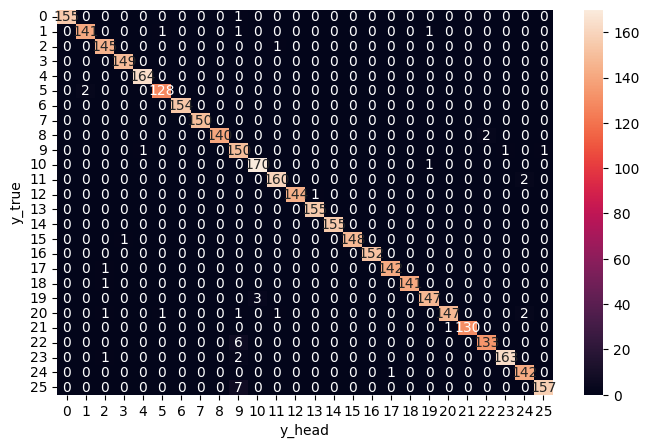

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_head")
plt.ylabel("y_true")
plt.show()

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [30]:
#Mengimport Model yang pembuat gunakan yaitu RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,roc_curve, auc, accuracy_score


#Memanggil Fungsi Model
RFC = RandomForestClassifier()
#fitting Model terhadap data training
RFC.fit(X_train, y_train)
y_pred = RFC.predict(X_test)
#Akurasi dari Data training
print(accuracy_score(y_test,y_pred)) #mencetak akurasi prediksi
print(classification_report(y_test,y_pred)) #mencetak classification report Precision, Recall, F1

0.9902130109383995
              precision    recall  f1-score   support

           A       1.00      0.99      1.00       194
           B       1.00      1.00      1.00       199
           C       0.97      0.99      0.98       190
           D       0.99      0.99      0.99       196
           E       1.00      1.00      1.00       200
           F       0.99      0.99      0.99       198
           G       0.99      1.00      0.99       212
           H       1.00      1.00      1.00       206
           I       1.00      1.00      1.00       201
           J       0.93      1.00      0.96       211
           K       0.95      1.00      0.98       191
           L       0.99      0.99      0.99       210
           M       1.00      0.99      0.99       202
           N       0.98      1.00      0.99       195
           O       0.99      1.00      1.00       185
           P       1.00      0.98      0.99       192
           Q       0.99      0.99      0.99       194
        

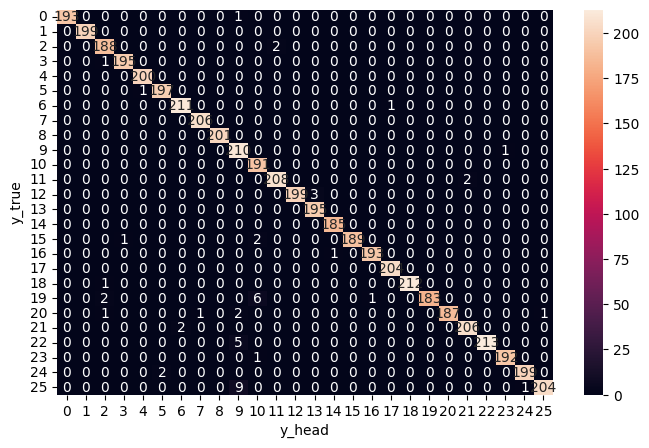

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_head")
plt.ylabel("y_true")
plt.show()

In [32]:
joblib.dump(RFC, "RFC_model.sav")

['RFC_model.sav']

# Testing

In [33]:
RFC = joblib.load("RFC_model.sav")

In [ ]:
cap = cv2.VideoCapture(0)

# Initiate holistic model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        curr_time = time.time()
        
        ret, frame = cap.read()

        # BGR 2 RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Flip on horizontal
        image = cv2.flip(image, 1)

        # Set flag
        image.flags.writeable = False

        # Detections
        results = holistic.process(image)
        
        # get image shape
        image_height, image_width, _ = image.shape

        # Set flag to true
        image.flags.writeable = True

        # RGB 2 BGR
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

        if results.right_hand_landmarks or results.left_hand_landmarks:
            # Mengambil Pose landmarks
            lh = list(np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3))
            rh = list(np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3))

            # Satukan baris
            row = lh+rh

            # Tambah class name 
            X = pd.DataFrame([row])
            hand_class = RFC.predict(X)[0]
            
            cv2.rectangle(image, (0,0), (120, 40), (245, 117, 16), -1)
            cv2.putText(image, 'CLASS',(10,15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, hand_class.split(' ')[0], (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2, cv2.LINE_AA)
        
        cv2.imshow('Testing Model', image)

        if cv2.waitKey(10) & 0xFF == ord('x'):
            break

cap.release()
cv2.destroyAllWindows()